In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 3.0 MB/s eta 0:00:01     |█████████████████▌              | 10.6 MB 3.0 MB/s eta 0:00:03
     |████████████████████████████████| 86 kB 3.8 MB/s  eta 0:00:01
     |████████████████████████████████| 453 kB 43.3 MB/s eta 0:00:01
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.0
    Uninstalling beautifulsoup4-4.9.0:
      Successfully uninstalled beautifulsoup4-4.9.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import re
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt

FILTERS="([~,.!?\"':;)(])"
PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

MAX_SEQUENCE = 25

def load_data(path):
    data_df = pd.read_csv(path, header=0)
    question, answer = list(data_df['Q']), list(data_df['A'])

    return question, answer

def data_tokenizer(data):
    words = []
    for sentence in data:
        sentence = re.sub(CHANGE_FILTER,"",sentence)
        for word in sentence.split():
            words.append(word)

    return [word for word in words if word]

def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in data:
        morphlized_seq = morph_analyzer.morphs(seq.replace(' ',''))
        result_data.append(morphlized_seq)

    return result_data

def load_vocabulary(path, vocab_path):
    vocabulary_list = list()
    if not os.path.exists(vocab_path):
        if (os.path.exists(path)):
            data_df = pd.read_csv(path, encoding='utf-8')
            question, answer = list(data_df['Q']), list(data_df['A'])
            data = []
            data.extend(question)
            data.extend(answer)

            words = data_tokenizer(data)
            words = list(set(words))
            words[:0] = MARKER # HEAD APPEND

        with open(vocab_path, 'w',encoding='utf-8') as vocabulary_file:
            for word in words:
                vocabulary_file.write(word+'\n')

    with open(vocab_path,'r',encoding='utf-8') as vocabulary_file:
        for line in vocabulary_file:
            vocabulary_list.append(line.strip())
        
    word2idx, idx2word = make_vocabulary(vocabulary_list)

    return word2idx, idx2word, len(word2idx)

def make_vocabulary(vocabulary_list):
    word2idx = {w:i for i,w in enumerate(vocabulary_list)}
    idx2word = {i:w for i,w in enumerate(vocabulary_list)}

    return word2idx, idx2word



def enc_processing(value, dictionary):
    sequences_input_index = []
    sequences_length = []

    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        sequence_index = []

        for word in sequence.split():
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            else:
                sequence_index.extend([dictionary[UNK]])

        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        
        sequences_length.append(len(sequences_length))

        # PADDING POST 
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_input_index.append(sequence_index)

    return np.asarray(sequences_input_index), sequences_length

def dec_output_processing(value, dictionary):
    sequences_output_index = []
    sequences_length = []

    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        sequence_index = [dictionary[STD]] + [dictionary[word] for word in sequence.split()]

        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        sequences_length.append(len(sequence_index))
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_output_index.append(sequence_index)
    
    return np.asarray(sequences_output_index), sequences_length

def dec_target_processing(value, dictionary):
    sequences_target_index = []
    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        sequence_index = [dictionary[word] for word in sequence.split()]
        
        if len(sequence_index) >= MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE-1] + [dictionary[END]]
        else:
            sequence_index += [dictionary[END]]

        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_target_index.append(sequence_index)

    return np.asarray(sequences_target_index)


In [3]:
import argparse
import os
import glob
import sys
from tqdm import tqdm
# from preprocess import *


def preprocess_data(PATH, VOCAB_PATH):
    inputs, outputs = load_data(PATH)
    char2idx, idx2char, vocab_size = load_vocabulary(PATH, VOCAB_PATH)
    index_inputs, input_seq_len = enc_processing(inputs, char2idx)
    index_outputs, output_seq_len = dec_output_processing(outputs, char2idx)
    index_targets = dec_target_processing(outputs, char2idx)

    data_configs = {}
    data_configs['char2idx'] = char2idx
    data_configs['idx2char'] = idx2char
    data_configs['vocab_size'] = vocab_size
    data_configs['pad_symbol'] = PAD
    data_configs['std_symbol'] = STD
    data_configs['end_symbol'] = END
    data_configs['unk_symbol'] = UNK

    DATA_IN_PATH = './'
    TRAIN_INPUTS = 'train_inputs.npy'
    TRAIN_OUTPUTS = 'train_outputs.npy'
    TRAIN_TARGETS = 'traiN_targets.npy'
    DATA_CONFIGS = 'data_configs.json'

    np.save(open(DATA_IN_PATH+TRAIN_INPUTS,'wb'),index_inputs)
    np.save(open(DATA_IN_PATH+TRAIN_OUTPUTS,'wb'),index_outputs)
    np.save(open(DATA_IN_PATH+TRAIN_TARGETS,'wb'),index_targets)

    json.dump(data_configs, open(DATA_IN_PATH+DATA_CONFIGS,'w'))
    print(len(input_seq_len),len(output_seq_len))
    

preprocess_data('../input/kot-chat/ChatbotData .csv','./vocabulary.txt')   

11823 11823


In [4]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

#from preprocessing import *
DATA_IN_PATH = './'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'traiN_targets.npy'
DATA_CONFIGS = 'data_configs.json'


SEED_NUM = 103
tf.random.set_seed(SEED_NUM)

index_inputs = np.load(open(DATA_IN_PATH+TRAIN_INPUTS,'rb'))
index_outputs = np.load(open(DATA_IN_PATH+TRAIN_OUTPUTS,'rb'))
index_targets = np.load(open(DATA_IN_PATH+TRAIN_TARGETS,'rb'))
prepro_configs = json.load(open(DATA_IN_PATH+DATA_CONFIGS,'r'))

print(len(index_inputs),len(index_outputs),len(index_targets))


11823 11823 11823


In [40]:
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string],'')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
    

In [5]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = .1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']


In [24]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))
    

In [32]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V  = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query,1)
        # Consider different Score metrics & Visualizing Attetion score when input come in 
        score = self.V(tf.nn.tanh(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector,axis=1)
        return context_vector, attention_weights
        

In [33]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer=
                                      'glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)
        self.attention = Attention(self.dec_units)
    
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_accurcay = tf.keras.metrics.SparseCategoricalAccuracy(name='accurcay')

def loss(real,pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accurcay(real, pred)
    
    return tf.reduce_mean(acc)

In [35]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz)
        
    def call(self,x):
        inp, tar = x
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        predict_tokens = []
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:,t],1),tf.float32)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output )
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
        return tf.stack(predict_tokens, axis=1)
    

    def inference(self, x):
        inp = x
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([char2idx[std_index]],1)
        predict_tokens = []
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token],0),tf.float32)
            
        return tf.stack(predict_tokens, axis=0).numpy()

In [36]:
model = seq2seq(vocab_size, EMBEDDING_DIM,UNITS,UNITS,BATCH_SIZE,char2idx[end_index])
model.compile(loss=loss,optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[accuracy])

PATH = './'+MODEL_NAME
if not (os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))
checkpoint_path = './'+MODEL_NAME+'/weights.h5'
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True)
earlystop_callback = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=10)
history = model.fit([index_inputs,index_outputs],index_targets,batch_size=BATCH_SIZE,epochs=EPOCH,validation_split=VALIDATION_SPLIT,callbacks=[earlystop_callback, cp_callback])


Epoch 1/30
5320/5320 [==============================] - ETA: 0s - loss: 1.3014 - accuracy: 0.8549
Epoch 00001: val_accuracy improved from -inf to 0.85332, saving model to ./seq2seq_kor/weights.h5
5320/5320 [==============================] - 884s 166ms/step - loss: 1.3014 - accuracy: 0.8549 - val_loss: 1.5199 - val_accuracy: 0.8533
Epoch 2/30
5320/5320 [==============================] - ETA: 0s - loss: 1.1393 - accuracy: 0.8540
Epoch 00002: val_accuracy improved from 0.85332 to 0.85463, saving model to ./seq2seq_kor/weights.h5
5320/5320 [==============================] - 879s 165ms/step - loss: 1.1393 - accuracy: 0.8540 - val_loss: 1.5686 - val_accuracy: 0.8546
Epoch 3/30
5320/5320 [==============================] - ETA: 0s - loss: 1.0436 - accuracy: 0.8556
Epoch 00003: val_accuracy improved from 0.85463 to 0.85629, saving model to ./seq2seq_kor/weights.h5
5320/5320 [==============================] - 874s 164ms/step - loss: 1.0436 - accuracy: 0.8556 - val_loss: 1.6139 - val_accuracy: 0.

5320/5320 [==============================] - 879s 165ms/step - loss: 0.0073 - accuracy: 0.9476 - val_loss: 2.9710 - val_accuracy: 0.9483
Epoch 26/30
5320/5320 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9490
Epoch 00026: val_accuracy improved from 0.94829 to 0.94959, saving model to ./seq2seq_kor/weights.h5
5320/5320 [==============================] - 882s 166ms/step - loss: 0.0070 - accuracy: 0.9490 - val_loss: 3.0669 - val_accuracy: 0.9496
Epoch 27/30
5320/5320 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9502
Epoch 00027: val_accuracy improved from 0.94959 to 0.95079, saving model to ./seq2seq_kor/weights.h5
5320/5320 [==============================] - 883s 166ms/step - loss: 0.0064 - accuracy: 0.9502 - val_loss: 3.0791 - val_accuracy: 0.9508
Epoch 28/30
5320/5320 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9514
Epoch 00028: val_accuracy improved from 0.95079 to 0.95191, saving model to ./seq2seq_kor/

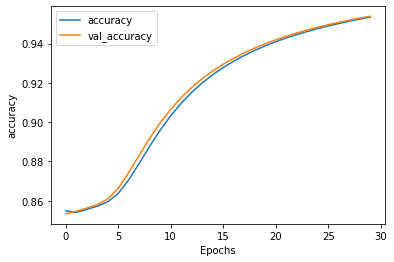

In [41]:
plot_graphs(history,'accuracy')

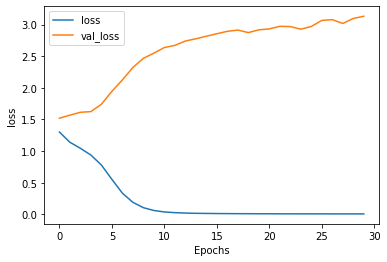

In [43]:
plot_graphs(history,'loss')

In [52]:
def get_query():
    while True:
        # Enter exit to exit
        query = input()
        if query == 'exit':
            break
        test_index_inputs,_ = enc_processing([query],word2idx)
        predict_tokens = model.inference(test_index_inputs)
        print(' '.join([idx2word[t] for t in predict_tokens]))
    
        

In [50]:
word2idx, idx2word, vocab_size = load_vocabulary('../input/kot-chat/ChatbotData .csv', './vocabulary.txt')

In [ ]:
get_query()